In [1]:
import os 
import sys
import ast
import pandas as pd
import seaborn as sns
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import fbprophet as pro

%matplotlib inline

# Importing data

## Pageview and revisions

In [2]:
combined_data = pd.read_csv('../data/test15/cleaned/combined.csv')
combined_data.timestamp = pd.to_datetime(combined_data.timestamp)
# In the interest of memory I'm going to immeadiately subset the combined data
combined_data = combined_data[['timestamp', 'revid', 'page_title', 'character_count', 
                               'external_link_count', 'heading_count', 'page_views',
                               'wikifile_count', 'wikilink_count', 'word_count']]

# combined_data = combined_data.reset_index()
# combined_data = combined_data.set_index(['page_title', 'timestamp'])

In [3]:
combined_data.sort_values(by=['page_title', 'timestamp'], inplace=True)

In [4]:
combined_data.head()

,timestamp,revid,page_title,character_count,external_link_count,heading_count,page_views,wikifile_count,wikilink_count,word_count
0,2015-07-01,NaN,'Amran,NaN,NaN,NaN,14.0,NaN,NaN,NaN
1,2015-07-02,NaN,'Amran,NaN,NaN,NaN,12.0,NaN,NaN,NaN
2,2015-07-03,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN
3,2015-07-04,NaN,'Amran,NaN,NaN,NaN,8.0,NaN,NaN,NaN
4,2015-07-05,NaN,'Amran,NaN,NaN,NaN,13.0,NaN,NaN,NaN


## Category data

In [5]:
category_data = pd.read_csv('../data/test15/cleaned/category_data.csv')

In [6]:
category_data.head()

,Unnamed: 0,page_title,revid,categories
0,0,Aubre de Lambert Maynard,786130355.0,[]
1,1,Nabla,715468992.0,[]
2,2,President-elect of the United States,670644904.0,"['Titles', 'Elections in the United States']"
3,3,Space Oddity,672181778.0,"['1975 singles', 'Song recordings produced by ..."
4,4,Tillakaratne Dilshan,669932370.0,"['Sri Lankan Buddhists', 'People from Western ..."


## Links pointing to pages

In [7]:
pointer_data = pd.read_csv('../data/test15/cleaned/pointers.csv')

In [8]:
pointer_data.head()

,Unnamed: 0,page_title,talk_link_count,wiki_link_count,wikipeida_count,user_count
0,15,'Amran,1,68,0,0
1,16,'Amran Governorate,1,103,0,0
2,17,'Asir Region,9,97,0,0
3,19,'Hours...',10,7,0,0
4,20,+1 button,0,2,0,0


# Identifying important categories

In [9]:
category_dict = {}
# category_data.set_index('page_title', inplace=True)

for page_title, df in category_data.iterrows():
    # lists were converted to a single string parsing them with ast
    for category in ast.literal_eval(df['categories']):
        try:
            category_dict[category] += 1
        except:
            category_dict[category] = 1


In [10]:
category_df = pd.DataFrame.from_dict(category_dict, orient='index')

In [11]:
category_df = category_df.sort_values(by=0, ascending=False)

In [12]:
category_df.iloc[:50]

,0
Living people,957
Articles containing video clips,195
American people of Irish descent,101
American people of English descent,100
Grammy Award winners,99
21st-century American writers,79
Battles of World War I involving Germany,78
World Digital Library related,77
20th-century American writers,75
American people of German descent,73


In [13]:
# subsetting a selection of categories

list_of_categories = ['Living people', 'Grammy Award winners', 
                      '21st-century American writers', '20th-century American writers',
                      'Member states of the United Nations', 'American films',
                      'American political writers', 'Machine learning']

In [43]:
# Pulling out the page titles which have these pages

category_dict = {}
category_data.set_index('page_title', inplace=True)

for page, df in category_data.iterrows():
    for category in ast.literal_eval(df['categories']):
        if category in list_of_categories:
            try:
                category_dict[category].append(page)
            except:
                category_dict[category] = [page]

# Determing wikipedia revision summary data

Instead of knowing specific details of each edit it would be nice to know the number of edits that wikipedia page experinced in a single day

In [199]:
# Generating summary numbers for edits

# combined_data.set_index('timestamp', inplace=True)
number_of_edits = combined_data[['revid', 'page_title']].groupby('page_title')['revid'].resample('1d').count()
number_of_edits = number_of_edits.to_frame(name='number_of_edits')

In [200]:
number_of_edits.reset_index(inplace=True)

In [201]:
number_of_edits.set_index(['page_title', 'timestamp'], inplace=True)

In [202]:
combined_data.reset_index(inplace=True)
combined_data.set_index(['page_title', 'timestamp'],inplace=True)

In [203]:
combined_data = pd.concat([combined_data, number_of_edits], sort=False)

In [204]:
combined_data = combined_data.sort_index(level=1).sort_index(level=0)

In [205]:
# Resampling to deal with difficulties in aligning data

combined_data.reset_index(inplace=True)
combined_data.set_index('timestamp', inplace=True)
combined_data = combined_data.groupby('page_title').resample('1d').mean()

# Data analysis 

## Forcasting activity on Wikipedia with all data

### Page veiws

In [100]:
combined_data.reset_index(inplace=True)
resampled_data = combined_data[['timestamp', 'page_views']]
resampled_data.columns = ['ds', 'y']

In [101]:
resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.dropna(inplace=True)
resampled_data.y = np.log10(resampled_data.y)
resampled_data.reset_index(inplace=True)

In [102]:
m = pro.Prophet()
m.fit(resampled_data);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [103]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

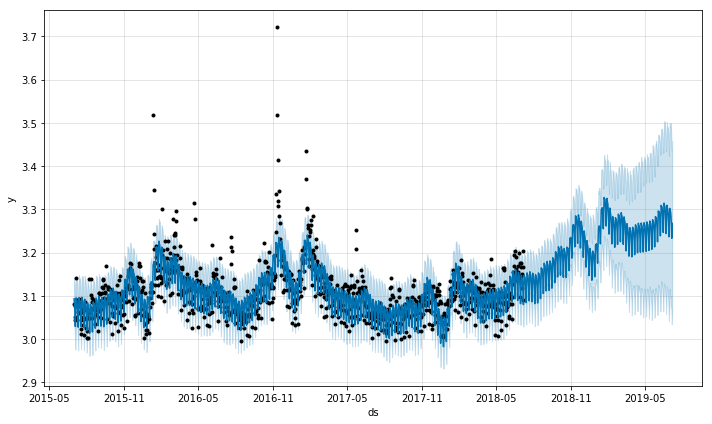

In [104]:
fig1 = m.plot(forecast)

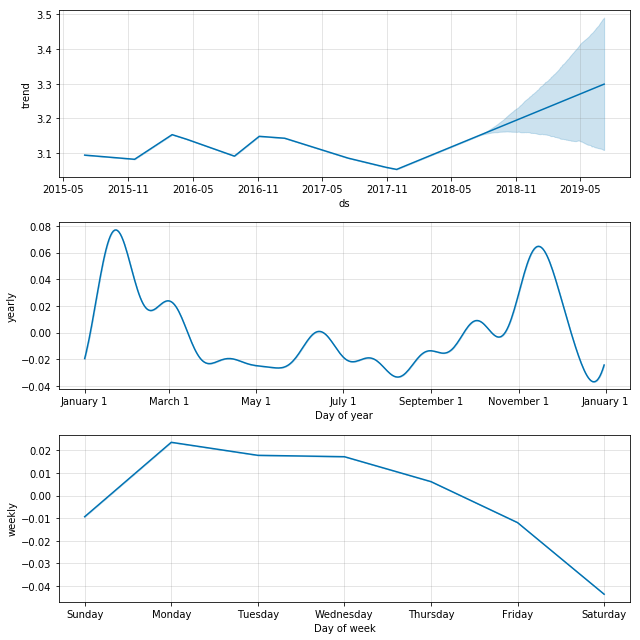

In [105]:
fig2 = m.plot_components(forecast)

### Edit frequency

In [28]:
resampled_data = combined_data[['timestamp', 'number_of_edits']]
resampled_data.columns = ['ds', 'y']

In [106]:
resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.reset_index(inplace=True)

In [30]:
m = pro.Prophet()
m.fit(resampled_data);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [31]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

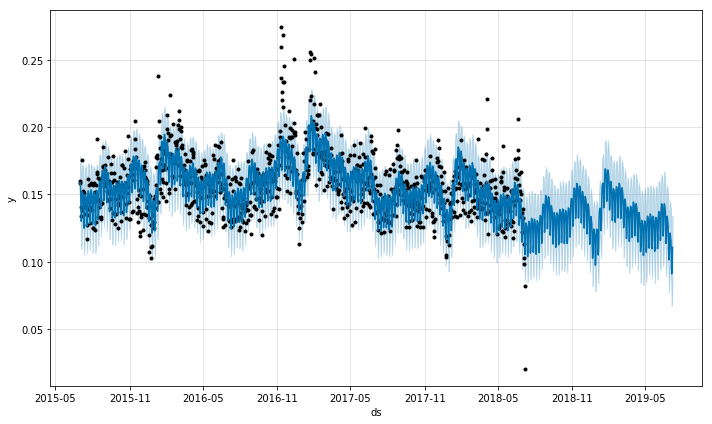

In [32]:
fig1 = m.plot(forecast)

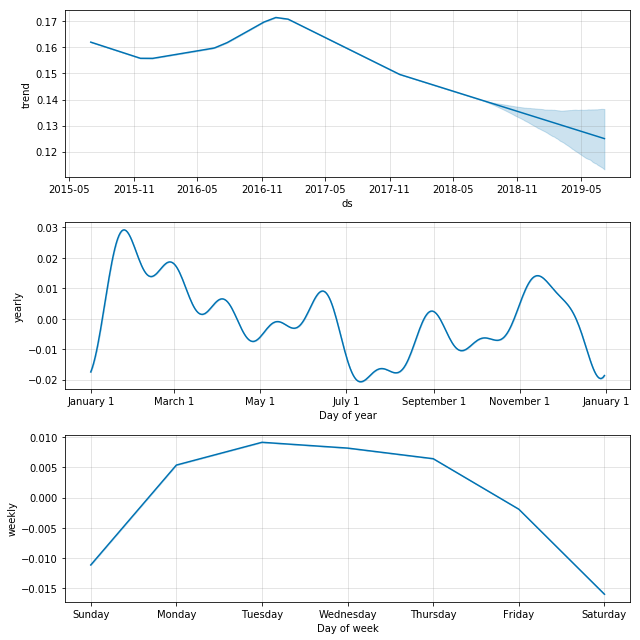

In [33]:
fig2 = m.plot_components(forecast)

It is important to note that weekly trends for both edits and pageviews follow the same trend of being dominantly carried out between Monday and Thursday of the week. This is counter to what I expected as I assumed people would take the time to edit wikipeida when they have excessive free time on the weekends. That said this analysis does not consider the types of edits that are carried out. It is possible that "major edits" or edits that would require a significant amount of time to implement would take place during weekends. 

## Forcasting activity of wikipedia of articles about people or not about people

### Pages about people (pageviews)

In [107]:
pages_about_people = category_dict['Living people']

In [109]:
combined_data.reset_index(inplace=True)
resampled_data = combined_data[combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'page_views']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.dropna(inplace=True)
resampled_data.y = np.log10(resampled_data.y)
resampled_data.reset_index(inplace=True)

In [110]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


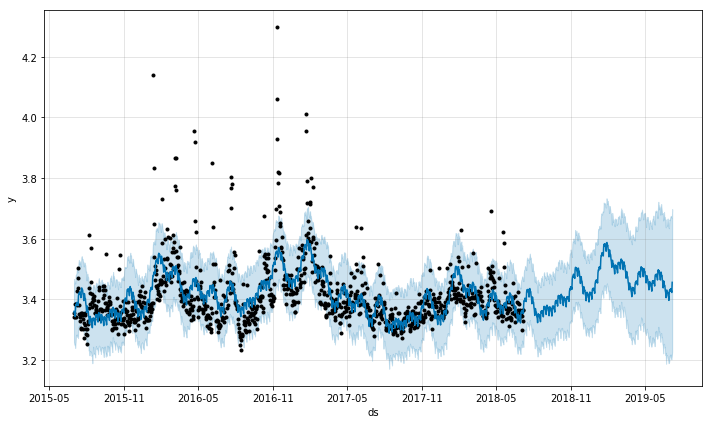

In [111]:
fig1 = m.plot(forecast)

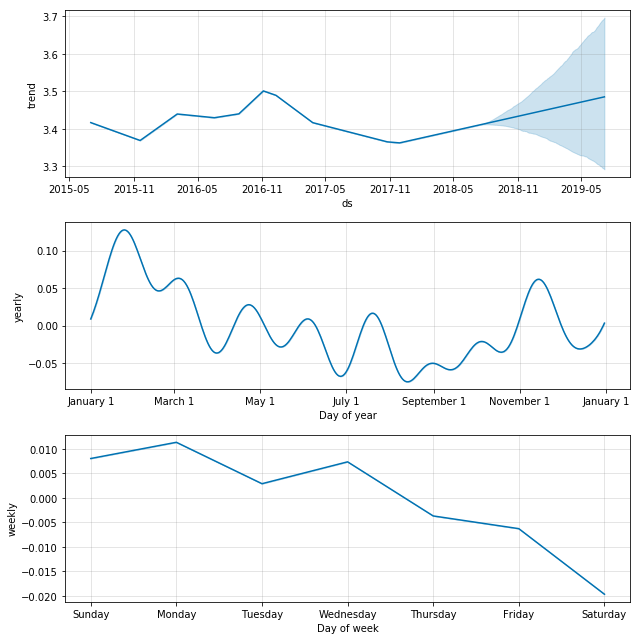

In [112]:
fig2 = m.plot_components(forecast)

### Pages about people (edit frequency)

In [113]:
# combined_data.reset_index(inplace=True)
resampled_data = combined_data[combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'number_of_edits']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.reset_index(inplace=True)

In [114]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


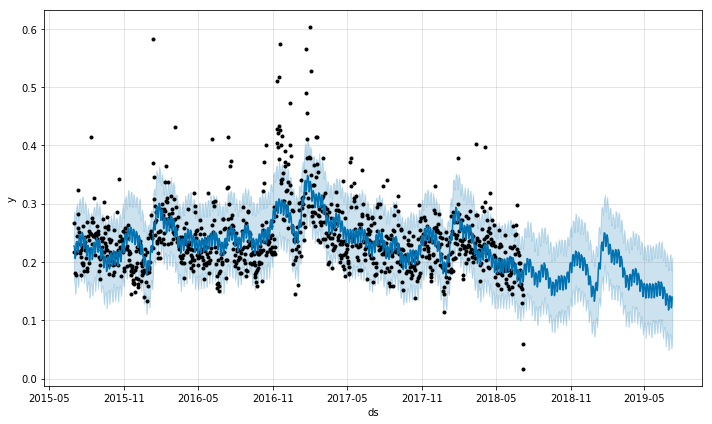

In [115]:
fig1 = m.plot(forecast)

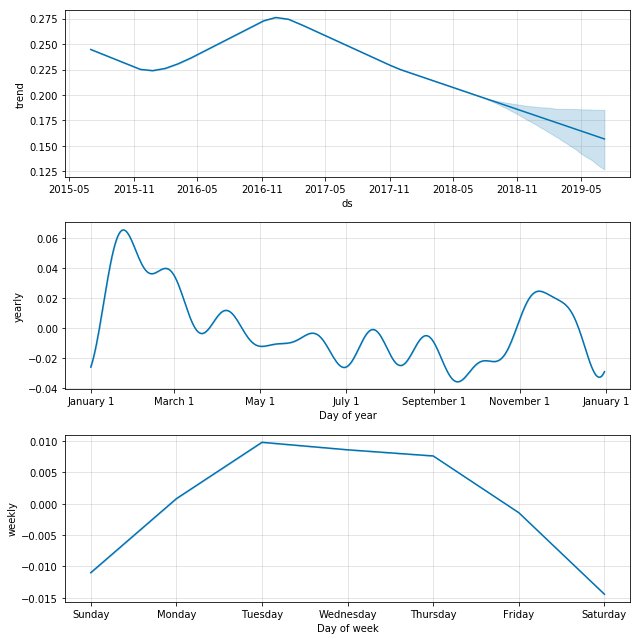

In [116]:
fig2 = m.plot_components(forecast)

### Pages not about people (page views)

In [117]:
# combined_data.reset_index(inplace=True)
resampled_data = combined_data[-combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'page_views']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.dropna(inplace=True)
resampled_data.y = np.log10(resampled_data.y)
resampled_data.reset_index(inplace=True)

In [118]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


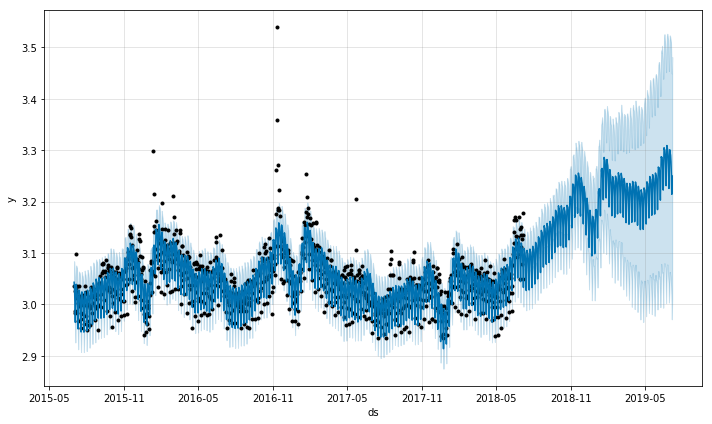

In [119]:
fig1 = m.plot(forecast)

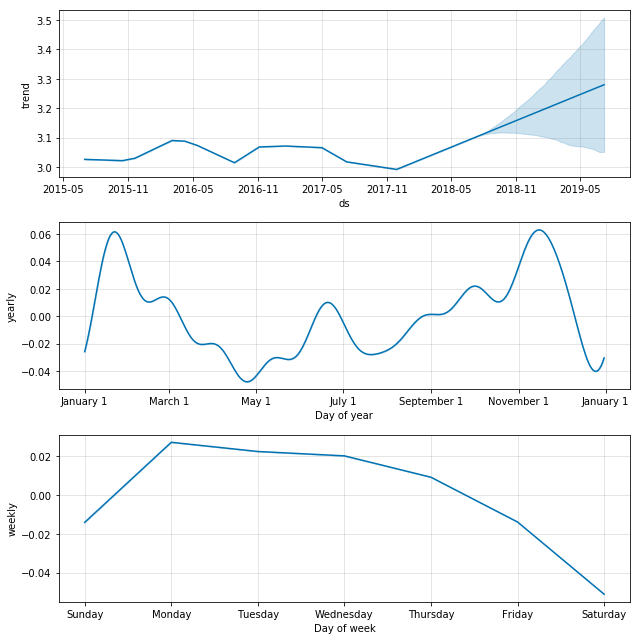

In [120]:
fig2 = m.plot_components(forecast)

### Pages not about people (Edit frequency)

In [121]:
# combined_data.reset_index(inplace=True)
resampled_data = combined_data[-combined_data.page_title.isin(pages_about_people)]
resampled_data = resampled_data[['timestamp', 'number_of_edits']]
resampled_data.columns = ['ds', 'y']

# Reducing the data 

resampled_data.set_index('ds', inplace=True)
resampled_data = resampled_data.resample('1D').mean()
resampled_data.reset_index(inplace=True)

In [122]:
m = pro.Prophet()
m.fit(resampled_data);

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


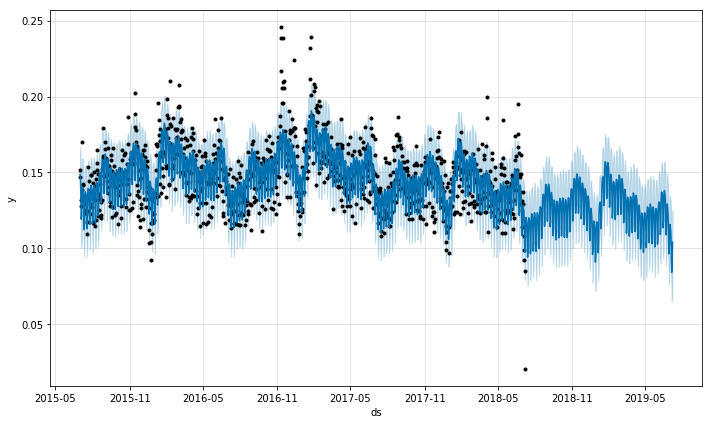

In [123]:
fig1 = m.plot(forecast)

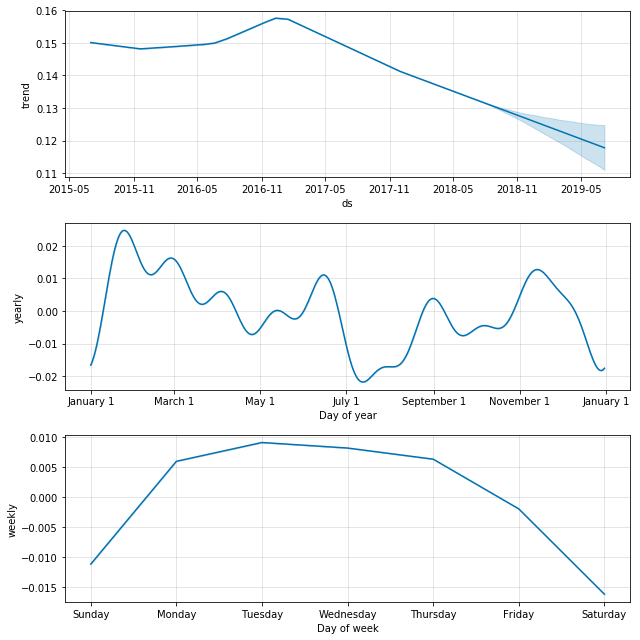

In [124]:
fig2 = m.plot_components(forecast)